In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd

[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1982","2010"]
file_path = os.path.expandvars('$HOME/data/oisst/sst.mon.mean.nc')
ds = xr.open_dataset(file_path)
sst = ds['sst'].isel(time=0)

file_path = os.path.expandvars('$WORK/data/CMIP6/AWI-CM-1-1-HR/regrid/tos_his_1981-2010_r360_180.nc')
ds = xr.open_dataset(file_path)
lat = ds['lat'].sel(lat=slice(ymin,ymax)).values
lon = ds['lon'].sel(lon=slice(xmin,xmax)).values
time = ds['time'].values  
time_dates = pd.to_datetime(time)  # 转换为 datetime 对象
time_years = time_dates.year + (time_dates.month - 1) / 12

sst_interp = sst.interp(lat=lat, lon=lon)

coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst_interp[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  


In [3]:
# cmip6 tos
root_dir = '/gxfs_work/geomar/smomw639/data/CMIP6/'

model = []
tos = []
# Get the list of subdirectories and sort them
subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
subdirs.sort(key=lambda d: d.lower())  # Sort the subdirectories in alphabetical order

# Walk through the sorted list of subdirectories
for subdir in subdirs:
    target_file = 'regrid/tos_his_1981-2010_r360_180.nc'
    file_path = os.path.join(subdir, target_file)
    if os.path.isfile(file_path):
        ds = xr.open_dataset(file_path)
        tos.append(ds['tos'].sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax),time=slice(tmin,tmax)).values)
        model.append(os.path.basename(subdir))
ds = xr.open_dataset(os.path.expandvars('$HOME/data/oisst/sst.mon.mean.nc'))
tos.append(ds['sst'].sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax),time=slice(tmin,tmax)).interp(lat=lat, lon=lon).values)
model.append('OISST')
sst=np.array(tos)

n = 2
sstc = np.empty((sst.shape[0],sst.shape[1],len(coast['lat']), n))
ssto = np.empty((sst.shape[0],sst.shape[1],len(coast['lat']), n))
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))


for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    sstc[:,:, point_idx, :] = sst[:,:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal band
    ssto[:,:, point_idx, :] = sst[:,:, lat_idx, int(lon_idx-n-n) : int(lon_idx-n)]  # offshore band
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]
sstu=sstc-ssto
sstum=np.mean(sstu.reshape(sstu.shape[0],int(sstu.shape[1]/12),12,sstu.shape[2],sstu.shape[3]), axis=1)


/tmp/ipykernel_3167248/304632674.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(t)}°N' for t in y_ticks])


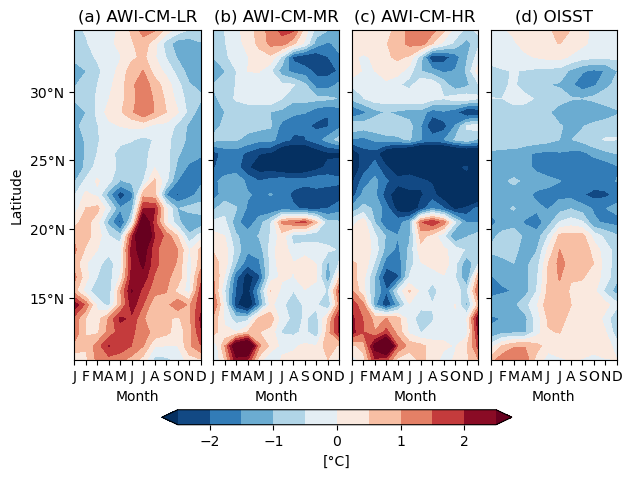

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(7, 5))

# 🔹 reserve bottom space BEFORE plotting
fig.subplots_adjust(bottom=0.22, wspace=0.1)

labels = ['(a)', '(b)', '(c)', '(d)']
models = ['AWI-CM-LR', 'AWI-CM-MR', 'AWI-CM-HR', 'OISST']
titles = [f"{lab} {mod}" for lab, mod in zip(labels, models)]

datasets = [
    np.squeeze(sstum[1,:,:,:]),
    np.squeeze(sstum[2,:,:,:]),
    np.squeeze(sstum[0,:,:,:]),
    np.squeeze(sstum[3,:,:,:])
]

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
cl = 2.5
levels = np.linspace(-cl, cl, 11)

for i, (data, title, ax) in enumerate(zip(datasets, titles, axes)):
    hov_data = np.nanmean(data, axis=-1)

    cf = ax.contourf(
        np.arange(12), lat, hov_data.T,
        levels=levels, extend='both', cmap='RdBu_r'
    )

    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(month_labels)

    if i == 0:
        ax.set_ylabel('Latitude')
        y_ticks = ax.get_yticks()
        ax.set_yticklabels([f'{int(t)}°N' for t in y_ticks])
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])

# 🔹 colorbar axis in reserved space
cax = fig.add_axes([0.25, 0.09, 0.5, 0.03])
cbar = fig.colorbar(cf, cax=cax, orientation='horizontal')
cbar.set_label('[°C]')
plt.savefig("figA2.png", dpi=300, bbox_inches='tight')                    

plt.show()
